In [2]:
import scipy
from scipy.integrate import quad
import numpy as np
from numpy.linalg import inv, eig, qr, det
import math
import random

In [3]:
n = 100
p = 10

X = np.random.rand(n,p)

for count in range(n):
    X[count][0] = 1

L = [[0 for a in range(p)] for b in range(p)]
L[0][0]=1

for i in range(1,p):
    L[i][i] = 1 #random.random()
    
#L = np.matrix('1 0; 0 0.5')
    
#B = np.random.rand(p)
B = [0.01 for count in range(p)]
#t_0 = 0.3


w = 5
y = X @ B + np.random.rand(n)/1000
#y = np.random.rand(n)

#y = np.array([1,0,2])

In [6]:
## QR Decomposition of X

Q, R = qr(X)
#q = (t_0 ** 2) * (Q @ inv(R@R @ L @ L @ R.T) @ Q.T)

In [7]:
## Eigendecomposition of R(L^2)R^T

D_arr, V = eig(R @ L @ L @ R.T)
D = np.diag(D_arr) # Converting eigenvalues into eigenvalue matrix
d = 1 # Product of eigenvalues
for ele in D_arr:
    d = d*ele

In [8]:
## Storing important values
yTy = y.T @ y
yTQQTy = y.T @ Q @ Q.T @ y
yTQV = y.T @ Q @ V
VTQTy = V.T @ Q.T @ y

In [22]:
## Optimized probability function

def probability(tau):
    ## Determinant
    det = 1
    for d_i in D_arr:
        det *= (1+(tau**2)*d_i)

    ##Difficult multiplication term
    mult = yTy - yTQQTy + (yTQV @ inv(D+(1/(tau**2))*np.identity(p)) @ VTQTy)/(tau**2)

    return det**(-0.5) * ((w/2 + mult/2)**(-0.5*(n+w)))*(1/((tau**(-1))*(1+tau**(-2))))


In [11]:
## Unoptimized probability

def unop_probability(tau):
    ## Determinant
    det = 1
    for d_i in D_arr:
        det *= (1+(tau**2)*d_i)
        
    ## REALLY difficult multiplication term
    mat = inv(np.identity(n)+(tau**2)*(X@L@L@X.T))
    return det**(-0.5) * ((w/2 + (y.T @ mat @ y)/2)**(-0.5*(n+w)))*(1/((tau**(-1))*(1+tau**(-2))))

In [12]:
## Approximating the integral of the probability density function over all positive reals

def g(NORM_STEP = 0.1, NORM_THRESHOLD = 0.0001, initial = 0.001):
    #return quad(probability, 0.0001, 100)
    
    ## Initialize lower and upper vals
    lower = initial
    upper = lower + NORM_STEP
    prob = lambda x: probability(x)
    val = (prob(lower) + prob(upper))/2 * NORM_STEP
    
    ## Res is ultimately returned
    res = 0
    
    ## While there's a lot of change to res
    while res == 0 or (abs((val-res)/res) > NORM_THRESHOLD):
        res = val
        lower = lower + NORM_STEP
        upper = upper + NORM_STEP
        val += (prob(lower) + prob(upper))/2 * NORM_STEP
    return res, upper
    
    

In [13]:
print(g(0.01, 0.0001))
print(g(0.1, 0.0001))
print(g(0.01, 0.00001))
print(g(0.1, 0.00001))

(1.90953876073736e-25, 1.0910000000000006)
(1.915446706458463e-25, 1.6010000000000004)
(1.9124178642683206e-25, 1.491000000000001)
(1.9157741142656575e-25, 2.101000000000001)


In [16]:
## Inverse CDF of x

def F_inv(x, NORM_STEP = 0.001, NORM_THRESHOLD = 0.0001, initial = 0.001):
    if x > 1:
        return math.inf
    
    ## Initializing lower and upper bounds
    lower = initial
    upper = initial + NORM_STEP
    
    ## Calling normalizing constant
    scal = g(NORM_STEP, NORM_THRESHOLD, initial)[0]
    prob = lambda x: probability(x)
    res = (prob(lower) + prob(upper))/2 * NORM_STEP
    
    ## While we're less than the normalizing constant times x, increment the result
    while res < x*scal:
        lower = lower + NORM_STEP
        upper = upper + NORM_STEP
        res += (prob(lower) + prob(upper))/2 * NORM_STEP
        
    return upper
    '''
    bound = 0.01
    prob = lambda x: probability(x)
    scal = g()[0]
    val = quad(prob, 0.000001, bound)[0]/scal
    print(bound)
    print(val)
    print("------------------")
    while (abs(val - x) > OUTPUT_THRESHOLD):
        bound = bound * x/val
        val = quad(prob, 0, bound)[0]/scal
        print(bound)
        print(val)
        print("--------------")
    
    return bound
    '''
    

In [18]:
F_inv(0.2)

0.17900000000000013

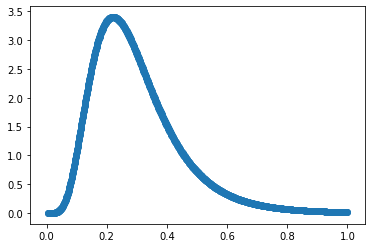

In [20]:
## Plotting optimized probability

g_val = g()[0]

import matplotlib.pyplot as plt
a = [(i+0.01)/1000.0 for i in range(5,1000)]
b = [probability(j)/g_val for j in a]
plt.scatter(a,b)
plt.show()

In [ ]:
probability(0.09)/

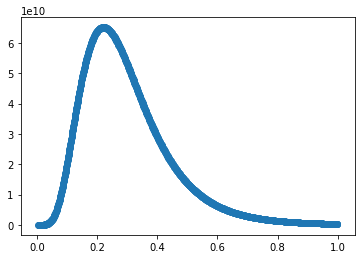

In [21]:
## Plotting unoptimized probability

g_val = g()[0]

import matplotlib.pyplot as plt
a = [(i+0.01)/1000.0 for i in range(5,1000)]
b = [unop_probability(j)*(10**(35)) for j in a]
plt.scatter(a,b)